In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# FSC COMPARISON: Reference GeoTIFF vs SnowMapPy
# ═══════════════════════════════════════════════════════════════════════════════
# This notebook performs a comprehensive spatial comparison between:
#   - Reference: Fractional Snow Cover from GeoTIFF files
#   - SnowMapPy: NDSI Snow Cover converted to FSC from Zarr dataset
#
# Key steps:
#   1. Load both datasets
#   2. Clip SnowMapPy to watershed boundary (shapefile)
#   3. Reproject Reference to match SnowMapPy grid (EPSG:4326)
#   4. Convert NDSI to FSC: FSC = 0.865 * NDSI + 0.26 (where NDSI >= 0.2)
#   5. Perform spatial comparisons
# ═══════════════════════════════════════════════════════════════════════════════

import xarray as xr
import rioxarray
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
import geopandas as gpd
from shapely.geometry import mapping
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

# Fix PROJ database issue
import pyproj
proj_data_path = pyproj.datadir.get_data_dir()
os.environ['PROJ_DATA'] = proj_data_path
os.environ['PROJ_LIB'] = proj_data_path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titleweight'] = 'bold'

# Color scheme
REF_COLOR = '#3498db'      # Blue for Reference
SMP_COLOR = '#e74c3c'      # Red for SnowMapPy
DIFF_COLOR = '#9b59b6'     # Purple for Difference

print("═" * 60)
print("   FSC COMPARISON: Reference vs SnowMapPy")
print("═" * 60)

════════════════════════════════════════════════════════════
   FSC COMPARISON: Reference vs SnowMapPy
════════════════════════════════════════════════════════════


Shapefile loaded: E:\PhD\Data\OUER 100m shp\BV_OumErrabia_1000.shp
  - CRS: EPSG:4326
  - Bounds: [-7.32082041 31.33844734 -5.06515073 33.21089572]
  - Area: 0 km²


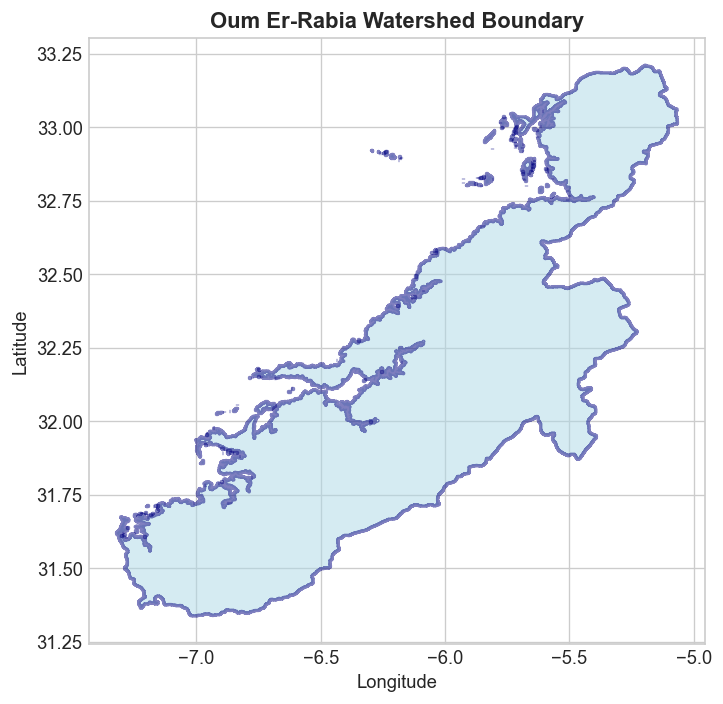

In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 1: LOAD SHAPEFILE FOR CLIPPING
# ═══════════════════════════════════════════════════════════════════════════════
# The shapefile defines the watershed boundary (Oum Er-Rabia basin)
# SnowMapPy data will be clipped to this boundary for accurate comparison

shp_path = r"E:\PhD\Data\OUER 100m shp\BV_OumErrabia_1000.shp"
watershed = gpd.read_file(shp_path)

print(f"Shapefile loaded: {shp_path}")
print(f"  - CRS: {watershed.crs}")
print(f"  - Bounds: {watershed.total_bounds}")
print(f"  - Area: {watershed.geometry.area.sum() / 1e6:.0f} km²")

# Reproject to EPSG:4326 if needed
if watershed.crs != 'EPSG:4326':
    watershed_4326 = watershed.to_crs('EPSG:4326')
    print(f"  - Reprojected to EPSG:4326")
else:
    watershed_4326 = watershed

# Display watershed extent
fig, ax = plt.subplots(figsize=(8, 6))
watershed_4326.plot(ax=ax, facecolor='lightblue', edgecolor='navy', linewidth=2, alpha=0.5)
ax.set_title('Oum Er-Rabia Watershed Boundary', fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 2: LOAD SNOWMAPPY DATA AND CLIP TO WATERSHED
# ═══════════════════════════════════════════════════════════════════════════════

print("Loading SnowMapPy data...")
smp_dataset_path = r"E:\SnowMapPy tests\SMP_OUER.zarr"
smp_dataset = xr.open_zarr(smp_dataset_path)
smp_ndsi = smp_dataset['NDSI_Snow_Cover']

print(f"  - Original shape: {smp_ndsi.shape}")
print(f"  - Time range: {pd.Timestamp(smp_ndsi.time.values[0]).date()} to {pd.Timestamp(smp_ndsi.time.values[-1]).date()}")
print(f"  - Lat range: {smp_ndsi.lat.values.min():.4f} to {smp_ndsi.lat.values.max():.4f}")
print(f"  - Lon range: {smp_ndsi.lon.values.min():.4f} to {smp_ndsi.lon.values.max():.4f}")

# Set CRS for SnowMapPy (it's in EPSG:4326)
smp_ndsi = smp_ndsi.rio.write_crs('EPSG:4326')
smp_ndsi = smp_ndsi.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

# Clip to watershed
print("\nClipping to watershed boundary...")
smp_clipped = smp_ndsi.rio.clip(watershed_4326.geometry, watershed_4326.crs, drop=True)
print(f"  - Clipped shape: {smp_clipped.shape}")

Loading SnowMapPy data...
  - Original shape: (430, 711, 9455)
  - Time range: 2000-02-27 to 2026-01-15
  - Lat range: 31.3404 to 33.3280
  - Lon range: -8.3581 to -5.0686

Clipping to watershed boundary...
  - Clipped shape: (404, 486, 9455)


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 3: CONVERT NDSI TO FSC
# ═══════════════════════════════════════════════════════════════════════════════
# Formula: FSC = 0.865 * NDSI + 0.26 (where NDSI >= 0.2)
# Step 1: Normalize NDSI (divide by 100 to get 0-1 range)
# Step 2: Apply threshold (NDSI < 0.2 = no snow)
# Step 3: Apply linear transformation

print("Converting NDSI to Fractional Snow Cover (FSC)...")

# Step 1: Normalize (preserve NaN values)
smp_normalized = smp_clipped / 100.0

# Step 2: Create a mask for valid pixels (not NaN)
valid_mask = ~np.isnan(smp_normalized)

# Step 3: Apply threshold only to valid pixels (NDSI < 0.2 = no snow = 0)
# Keep NaN for invalid pixels (outside study area)
smp_thresholded = xr.where(valid_mask & (smp_normalized >= 0.2), smp_normalized, 0)
smp_thresholded = xr.where(valid_mask, smp_thresholded, np.nan)

# Step 4: Apply FSC conversion (only where snow exists and data is valid)
# FSC = 0.865 * NDSI + 0.26 (only where NDSI >= 0.2)
smp_fsc = xr.where(smp_thresholded > 0, 0.865 * smp_thresholded + 0.26, 0)
smp_fsc = xr.where(valid_mask, smp_fsc, np.nan)

# Step 5: Flip vertically to correct the upside-down orientation
smp_fsc = smp_fsc.isel(lat=slice(None, None, -1))

# Verify NaN preservation
valid_pixels = (~np.isnan(smp_fsc.isel(time=0).values)).sum()
total_pixels = smp_fsc.isel(time=0).values.size
print(f"  ✓ FSC range: {float(smp_fsc.min()):.3f} to {float(smp_fsc.max()):.3f}")
print(f"  ✓ Applied formula: FSC = 0.865 × NDSI + 0.26 (where NDSI ≥ 0.2)")
print(f"  ✓ Orientation corrected (flipped vertically)")
print(f"  ✓ Valid pixels in first timestep: {valid_pixels}/{total_pixels} ({valid_pixels/total_pixels*100:.1f}%)")

Converting NDSI to Fractional Snow Cover (FSC)...
  ✓ FSC range: 0.000 to 1.125
  ✓ Applied formula: FSC = 0.865 × NDSI + 0.26 (where NDSI ≥ 0.2)
  ✓ Orientation corrected (flipped vertically)
  ✓ Valid pixels in first timestep: 64345/196344 (32.8%)


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 4: LOAD REFERENCE GEOTIFF DATA
# ═══════════════════════════════════════════════════════════════════════════════

print("Loading Reference GeoTIFF data...")
tif_folder = r"C:\Users\Hatem\Downloads\OneDrive_1_31-01-2026"
tif_files = sorted([f for f in os.listdir(tif_folder) if f.endswith('.tif')])
dates = ['-'.join(f[:-4].split('_')[-3:]) for f in tif_files]

# Get CRS and transform from first file
sample_tif = os.path.join(tif_folder, tif_files[0])
with rasterio.open(sample_tif) as src:
    ref_crs = src.crs
    ref_transform = src.transform
    ref_bounds = src.bounds

print(f"  - Number of files: {len(tif_files)}")
print(f"  - Date range: {dates[0]} to {dates[-1]}")
print(f"  - CRS: {ref_crs}")
print(f"  - Bounds: {ref_bounds}")

Loading Reference GeoTIFF data...
  - Number of files: 365
  - Date range: 2008-09-01 to 2009-08-31
  - CRS: PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  - Bounds: BoundingBox(left=559218.4488491954, bottom=3468358.9959279844, right=868248.0307733158, top=3688432.5362787447)


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 5: REPROJECT REFERENCE DATA TO MATCH SNOWMAPPY GRID
# ═══════════════════════════════════════════════════════════════════════════════

from scipy.interpolate import RegularGridInterpolator
from pyproj import Transformer, CRS as PyprojCRS
from tqdm.notebook import tqdm

# Define target grid (SnowMapPy clipped grid)
target_lats = smp_fsc.lat.values
target_lons = smp_fsc.lon.values

print(f"Target grid (SnowMapPy clipped):")
print(f"  - Shape: {len(target_lats)} x {len(target_lons)}")
print(f"  - Lat: {target_lats.min():.4f} to {target_lats.max():.4f}")
print(f"  - Lon: {target_lons.min():.4f} to {target_lons.max():.4f}")

# Create transformer from UTM to WGS84
utm_crs = PyprojCRS.from_string(str(ref_crs))
wgs84_crs = PyprojCRS.from_epsg(4326)
transformer = Transformer.from_crs(utm_crs, wgs84_crs, always_xy=True)

def reproject_tiff_to_grid(tif_path, target_lats, target_lons, transformer):
    """Reproject GeoTIFF to EPSG:4326 and resample to target grid."""
    with rasterio.open(tif_path) as src:
        data = src.read(1).astype(np.float32)
        if src.nodata is not None:
            data[data == src.nodata] = np.nan
        data[data < 0] = np.nan
        data[data > 100] = np.nan
        
        # Get source pixel coordinates and transform to lat/lon
        rows, cols = np.meshgrid(np.arange(src.height), np.arange(src.width), indexing='ij')
        xs, ys = rasterio.transform.xy(src.transform, rows.flatten(), cols.flatten())
        lons, lats = transformer.transform(np.array(xs), np.array(ys))
        
        # Create regular grid in lat/lon
        src_lons_grid = np.linspace(lons.min(), lons.max(), src.width)
        src_lats_grid = np.linspace(lats.max(), lats.min(), src.height)
        
        try:
            interpolator = RegularGridInterpolator(
                (src_lats_grid, src_lons_grid), data,
                method='nearest', bounds_error=False, fill_value=np.nan
            )
            target_lat_grid, target_lon_grid = np.meshgrid(target_lats, target_lons, indexing='ij')
            target_coords = np.stack([target_lat_grid.ravel(), target_lon_grid.ravel()], axis=-1)
            return interpolator(target_coords).reshape(len(target_lats), len(target_lons))
        except:
            return np.full((len(target_lats), len(target_lons)), np.nan)

# Filter to overlapping time period
ref_dates = pd.to_datetime(dates)
smp_dates = pd.to_datetime(smp_fsc.time.values)
start_date = max(ref_dates.min(), smp_dates.min())
end_date = min(ref_dates.max(), smp_dates.max())

print(f"\nOverlapping period: {start_date.date()} to {end_date.date()}")

# Process all files
ref_mask = (ref_dates >= start_date) & (ref_dates <= end_date)
overlap_files = [f for f, m in zip(tif_files, ref_mask) if m]
overlap_dates = ref_dates[ref_mask]

print(f"Processing {len(overlap_files)} Reference files...")
ref_data_list = []
for f, d in tqdm(zip(overlap_files, overlap_dates), total=len(overlap_files)):
    reprojected = reproject_tiff_to_grid(os.path.join(tif_folder, f), target_lats, target_lons, transformer)
    ref_data_list.append(reprojected)

# Create xarray
ref_data = xr.DataArray(
    np.stack(ref_data_list, axis=0),
    coords=[pd.DatetimeIndex(overlap_dates), target_lats, target_lons],
    dims=['time', 'lat', 'lon']
)

print(f"\n✓ Reference data reprojected: {ref_data.shape}")

Target grid (SnowMapPy clipped):
  - Shape: 404 x 486
  - Lat: 31.3404 to 33.2075
  - Lon: -7.3157 to -5.0686

Overlapping period: 2008-09-01 to 2009-08-31
Processing 365 Reference files...


  0%|          | 0/365 [00:00<?, ?it/s]


✓ Reference data reprojected: (365, 404, 486)


In [21]:
# ═══════════════════════════════════════════════════════════════════════════════
# STEP 6: ALIGN DATASETS TO COMMON DATES
# ═══════════════════════════════════════════════════════════════════════════════

# Get common dates
ref_time_index = pd.DatetimeIndex(ref_data.time.values)
smp_time_index = pd.DatetimeIndex(smp_fsc.time.values)
common_dates = ref_time_index.intersection(smp_time_index)

print(f"Common dates: {len(common_dates)}")
print(f"Date range: {common_dates[0].date()} to {common_dates[-1].date()}")

# Select common dates and ensure same dimensions
ref_aligned = ref_data.sel(time=common_dates)
smp_fsc_transposed = smp_fsc.transpose('time', 'lat', 'lon')
smp_aligned = smp_fsc_transposed.sel(time=common_dates)

print(f"\nAligned datasets:")
print(f"  - Reference: {ref_aligned.shape}")
print(f"  - SnowMapPy: {smp_aligned.shape}")

Common dates: 365
Date range: 2008-09-01 to 2009-08-31

Aligned datasets:
  - Reference: (365, 404, 486)
  - SnowMapPy: (365, 404, 486)


Calculating valid pixels per day...


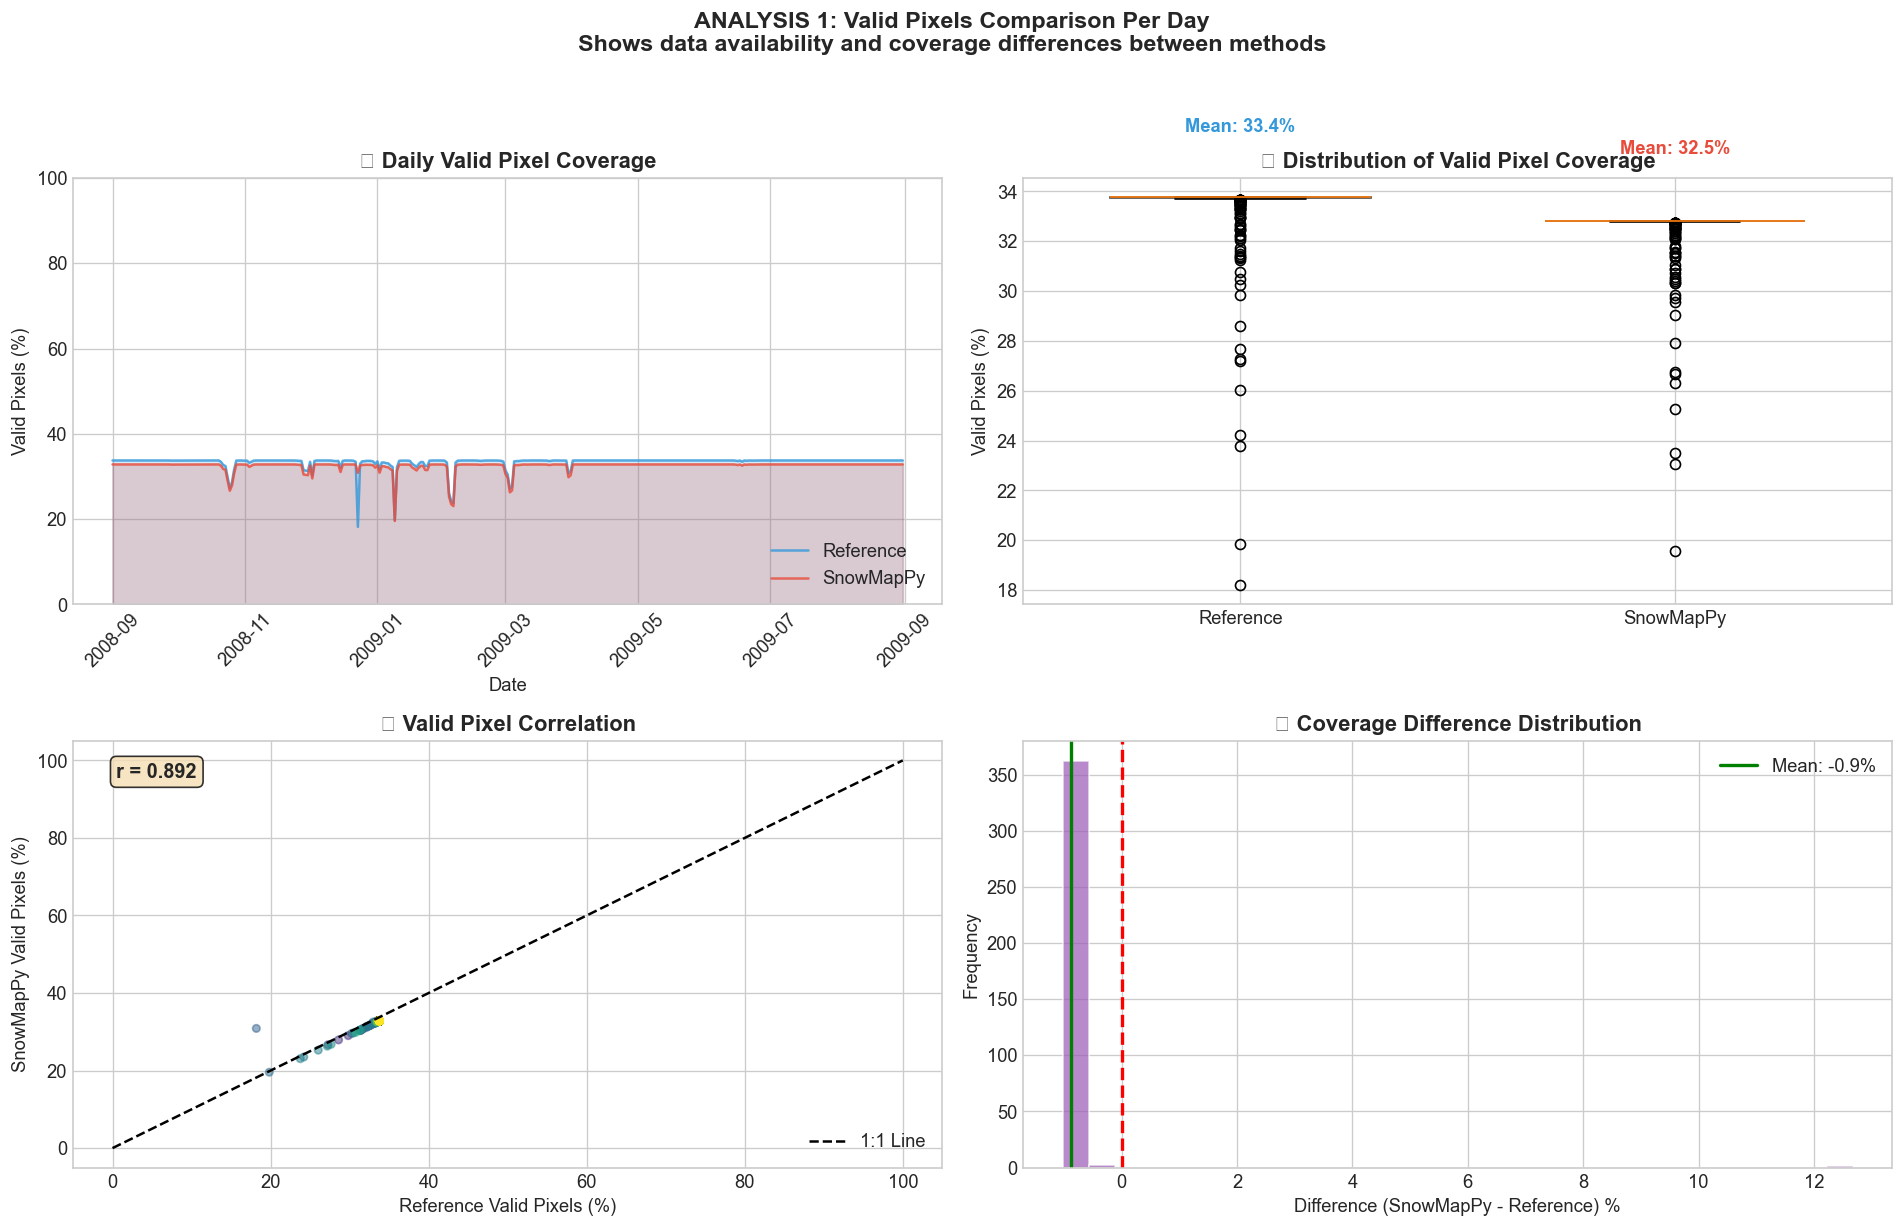


📊 Summary:
   Reference: Mean=33.4%, Min=18.2%, Max=33.8%
   SnowMapPy: Mean=32.5%, Min=19.6%, Max=32.8%


In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 1: VALID PIXELS COMPARISON PER DAY
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: How many pixels have valid (non-NaN) data each day.
# WHY IT'S USEFUL: Reveals data availability differences between methods,
#                  indicating cloud masking or processing differences.
# ═══════════════════════════════════════════════════════════════════════════════

print("Calculating valid pixels per day...")

# Calculate valid pixels for each day
total_pixels = ref_aligned.shape[1] * ref_aligned.shape[2]
ref_valid = [(~np.isnan(ref_aligned.isel(time=i).values)).sum() for i in range(len(common_dates))]
smp_valid = [(~np.isnan(smp_aligned.isel(time=i).values)).sum() for i in range(len(common_dates))]

# Convert to percentage
ref_valid_pct = [v / total_pixels * 100 for v in ref_valid]
smp_valid_pct = [v / total_pixels * 100 for v in smp_valid]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time series of valid pixels
ax1 = axes[0, 0]
ax1.plot(common_dates, ref_valid_pct, color=REF_COLOR, linewidth=1.5, label='Reference', alpha=0.8)
ax1.plot(common_dates, smp_valid_pct, color=SMP_COLOR, linewidth=1.5, label='SnowMapPy', alpha=0.8)
ax1.fill_between(common_dates, ref_valid_pct, alpha=0.2, color=REF_COLOR)
ax1.fill_between(common_dates, smp_valid_pct, alpha=0.2, color=SMP_COLOR)
ax1.set_xlabel('Date')
ax1.set_ylabel('Valid Pixels (%)')
ax1.set_title('📊 Daily Valid Pixel Coverage', fontweight='bold')
ax1.legend(loc='lower right')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Box plot comparison
ax2 = axes[0, 1]
bp = ax2.boxplot([ref_valid_pct, smp_valid_pct], labels=['Reference', 'SnowMapPy'], 
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor(REF_COLOR)
bp['boxes'][1].set_facecolor(SMP_COLOR)
for box in bp['boxes']:
    box.set_alpha(0.7)
ax2.set_ylabel('Valid Pixels (%)')
ax2.set_title('📦 Distribution of Valid Pixel Coverage', fontweight='bold')
ax2.text(1, np.mean(ref_valid_pct) + 3, f'Mean: {np.mean(ref_valid_pct):.1f}%', 
         ha='center', fontweight='bold', color=REF_COLOR)
ax2.text(2, np.mean(smp_valid_pct) + 3, f'Mean: {np.mean(smp_valid_pct):.1f}%', 
         ha='center', fontweight='bold', color=SMP_COLOR)

# Plot 3: Scatter plot (correlation)
ax3 = axes[1, 0]
ax3.scatter(ref_valid_pct, smp_valid_pct, alpha=0.5, c=range(len(common_dates)), cmap='viridis', s=20)
ax3.plot([0, 100], [0, 100], 'k--', linewidth=1.5, label='1:1 Line')
corr = np.corrcoef(ref_valid_pct, smp_valid_pct)[0, 1]
ax3.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax3.transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax3.set_xlabel('Reference Valid Pixels (%)')
ax3.set_ylabel('SnowMapPy Valid Pixels (%)')
ax3.set_title('🔗 Valid Pixel Correlation', fontweight='bold')
ax3.legend()

# Plot 4: Difference histogram
ax4 = axes[1, 1]
diff = np.array(smp_valid_pct) - np.array(ref_valid_pct)
ax4.hist(diff, bins=30, color=DIFF_COLOR, alpha=0.7, edgecolor='white')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax4.axvline(x=np.mean(diff), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(diff):+.1f}%')
ax4.set_xlabel('Difference (SnowMapPy - Reference) %')
ax4.set_ylabel('Frequency')
ax4.set_title('📈 Coverage Difference Distribution', fontweight='bold')
ax4.legend()

fig.suptitle('ANALYSIS 1: Valid Pixels Comparison Per Day\n'
             'Shows data availability and coverage differences between methods', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"   Reference: Mean={np.mean(ref_valid_pct):.1f}%, Min={np.min(ref_valid_pct):.1f}%, Max={np.max(ref_valid_pct):.1f}%")
print(f"   SnowMapPy: Mean={np.mean(smp_valid_pct):.1f}%, Min={np.min(smp_valid_pct):.1f}%, Max={np.max(smp_valid_pct):.1f}%")

Calculating missing values per day...


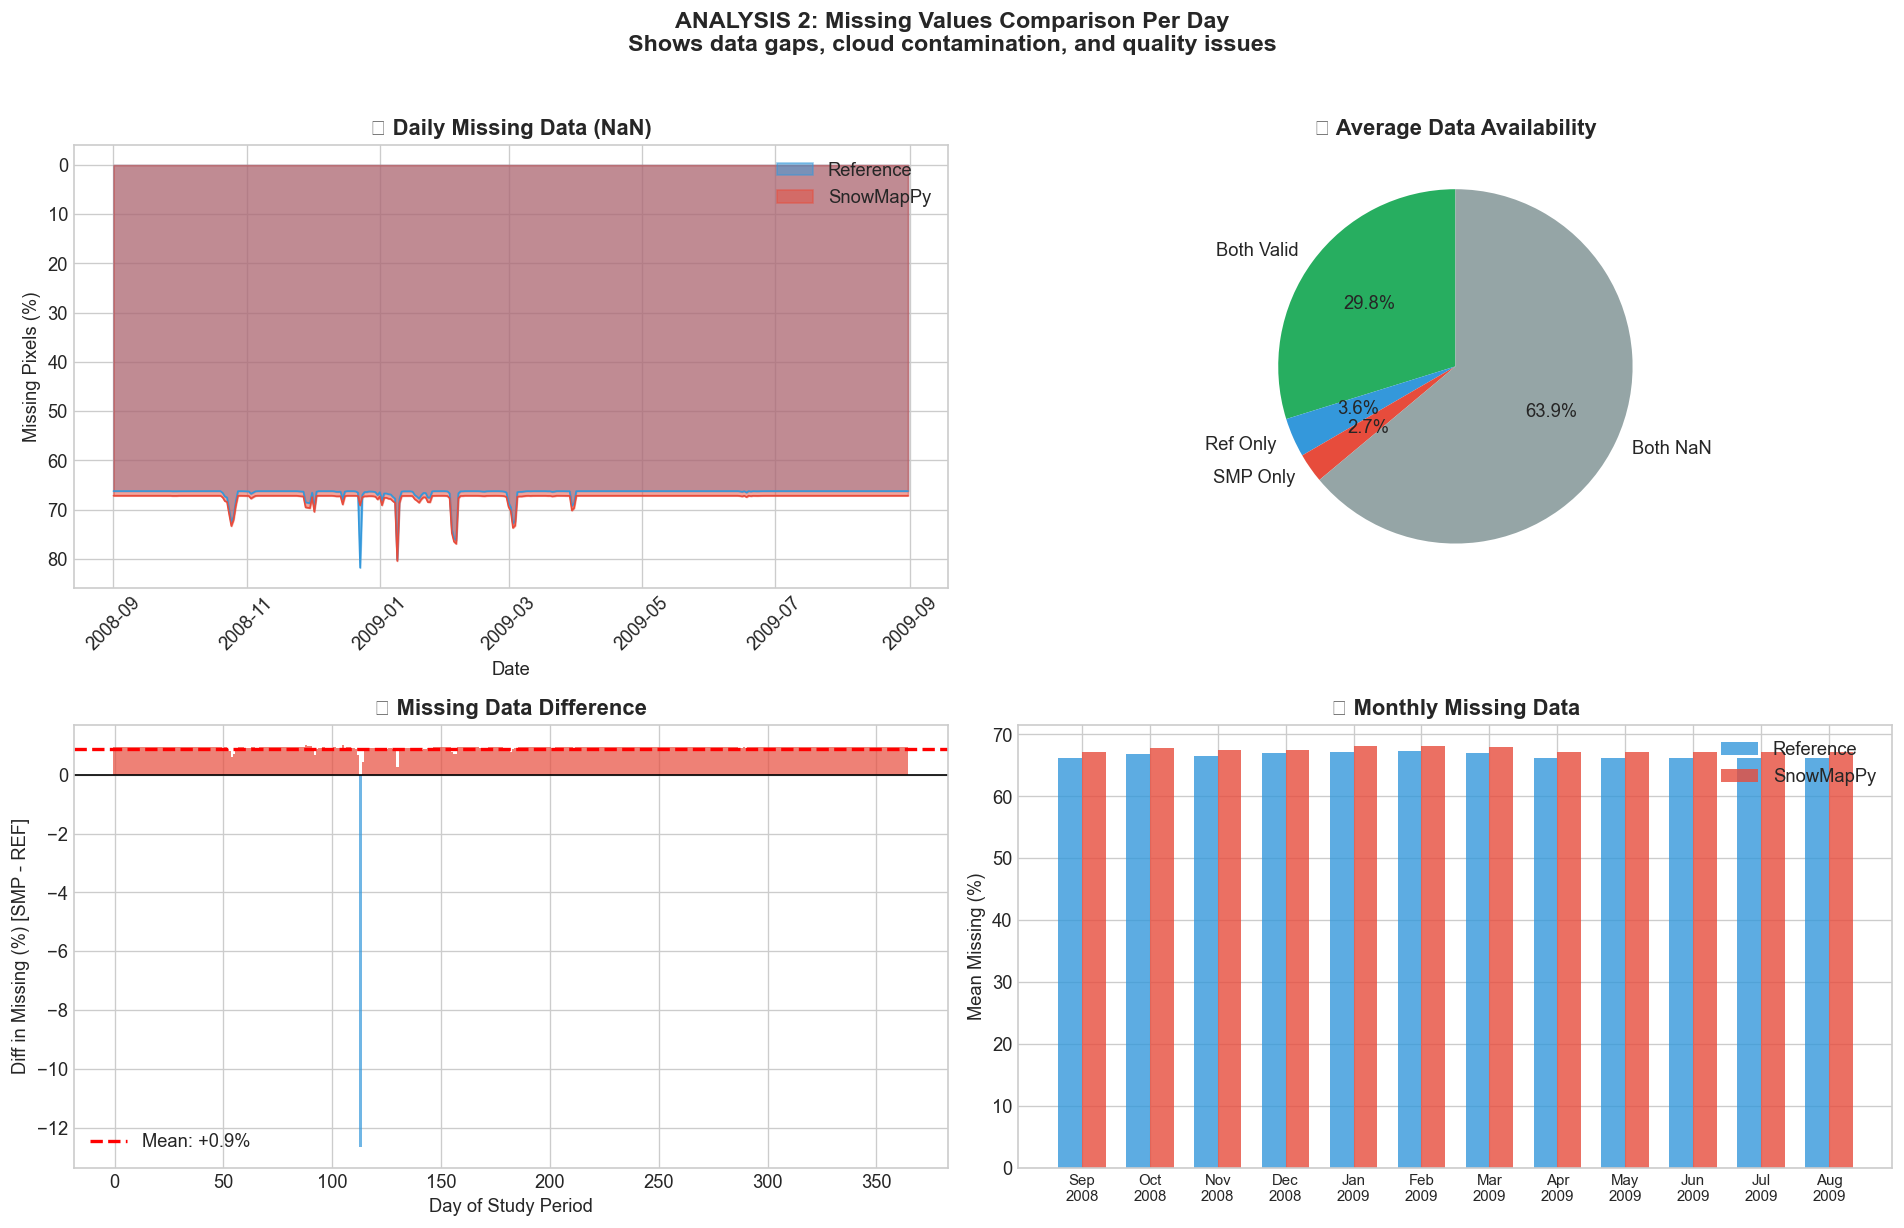


📊 Summary:
   Reference: Mean missing=66.6%
   SnowMapPy: Mean missing=67.5%
   Both Valid (avg): 58520 pixels (29.8%)


In [23]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 2: MISSING VALUES COMPARISON PER DAY
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: Number/percentage of NaN (missing) pixels each day.
# WHY IT'S USEFUL: Helps identify cloud contamination patterns, sensor gaps,
#                  and data quality differences between processing methods.
# ═══════════════════════════════════════════════════════════════════════════════

print("Calculating missing values per day...")

# Calculate missing pixels
ref_nan = [np.isnan(ref_aligned.isel(time=i).values).sum() for i in range(len(common_dates))]
smp_nan = [np.isnan(smp_aligned.isel(time=i).values).sum() for i in range(len(common_dates))]

ref_nan_pct = [v / total_pixels * 100 for v in ref_nan]
smp_nan_pct = [v / total_pixels * 100 for v in smp_nan]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Time series of missing values
ax1 = axes[0, 0]
ax1.fill_between(common_dates, ref_nan_pct, alpha=0.5, color=REF_COLOR, label='Reference')
ax1.fill_between(common_dates, smp_nan_pct, alpha=0.5, color=SMP_COLOR, label='SnowMapPy')
ax1.plot(common_dates, ref_nan_pct, color=REF_COLOR, linewidth=1)
ax1.plot(common_dates, smp_nan_pct, color=SMP_COLOR, linewidth=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Missing Pixels (%)')
ax1.set_title('📉 Daily Missing Data (NaN)', fontweight='bold')
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=45)
ax1.invert_yaxis()  # Lower is better

# Plot 2: Stacked bar showing categories
ax2 = axes[0, 1]
# Categories: Both valid, Ref only, SMP only, Both NaN
both_valid = []
ref_only = []
smp_only = []
both_nan = []

for i in range(len(common_dates)):
    ref_v = ~np.isnan(ref_aligned.isel(time=i).values)
    smp_v = ~np.isnan(smp_aligned.isel(time=i).values)
    both_valid.append((ref_v & smp_v).sum())
    ref_only.append((ref_v & ~smp_v).sum())
    smp_only.append((~ref_v & smp_v).sum())
    both_nan.append((~ref_v & ~smp_v).sum())

# Average values for pie chart
avg_vals = [np.mean(both_valid), np.mean(ref_only), np.mean(smp_only), np.mean(both_nan)]
labels = ['Both Valid', 'Ref Only', 'SMP Only', 'Both NaN']
colors_pie = ['#27ae60', REF_COLOR, SMP_COLOR, '#95a5a6']
ax2.pie(avg_vals, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax2.set_title('🎯 Average Data Availability', fontweight='bold')

# Plot 3: Difference in missing values
ax3 = axes[1, 0]
diff_nan = np.array(smp_nan_pct) - np.array(ref_nan_pct)
colors_bar = [SMP_COLOR if x > 0 else REF_COLOR for x in diff_nan]
ax3.bar(range(len(diff_nan)), diff_nan, color=colors_bar, alpha=0.7, width=1)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.axhline(y=np.mean(diff_nan), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(diff_nan):+.1f}%')
ax3.set_xlabel('Day of Study Period')
ax3.set_ylabel('Diff in Missing (%) [SMP - REF]')
ax3.set_title('📊 Missing Data Difference', fontweight='bold')
ax3.legend()

# Plot 4: Monthly missing data
ax4 = axes[1, 1]
monthly_ref = pd.Series(ref_nan_pct, index=common_dates).resample('M').mean()
monthly_smp = pd.Series(smp_nan_pct, index=common_dates).resample('M').mean()

x = np.arange(len(monthly_ref))
width = 0.35
ax4.bar(x - width/2, monthly_ref.values, width, label='Reference', color=REF_COLOR, alpha=0.8)
ax4.bar(x + width/2, monthly_smp.values, width, label='SnowMapPy', color=SMP_COLOR, alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels([d.strftime('%b\n%Y') for d in monthly_ref.index], fontsize=9)
ax4.set_ylabel('Mean Missing (%)')
ax4.set_title('📅 Monthly Missing Data', fontweight='bold')
ax4.legend()

fig.suptitle('ANALYSIS 2: Missing Values Comparison Per Day\n'
             'Shows data gaps, cloud contamination, and quality issues', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print(f"\n📊 Summary:")
print(f"   Reference: Mean missing={np.mean(ref_nan_pct):.1f}%")
print(f"   SnowMapPy: Mean missing={np.mean(smp_nan_pct):.1f}%")
print(f"   Both Valid (avg): {np.mean(both_valid):.0f} pixels ({np.mean(both_valid)/total_pixels*100:.1f}%)")

Analyzing FSC values...


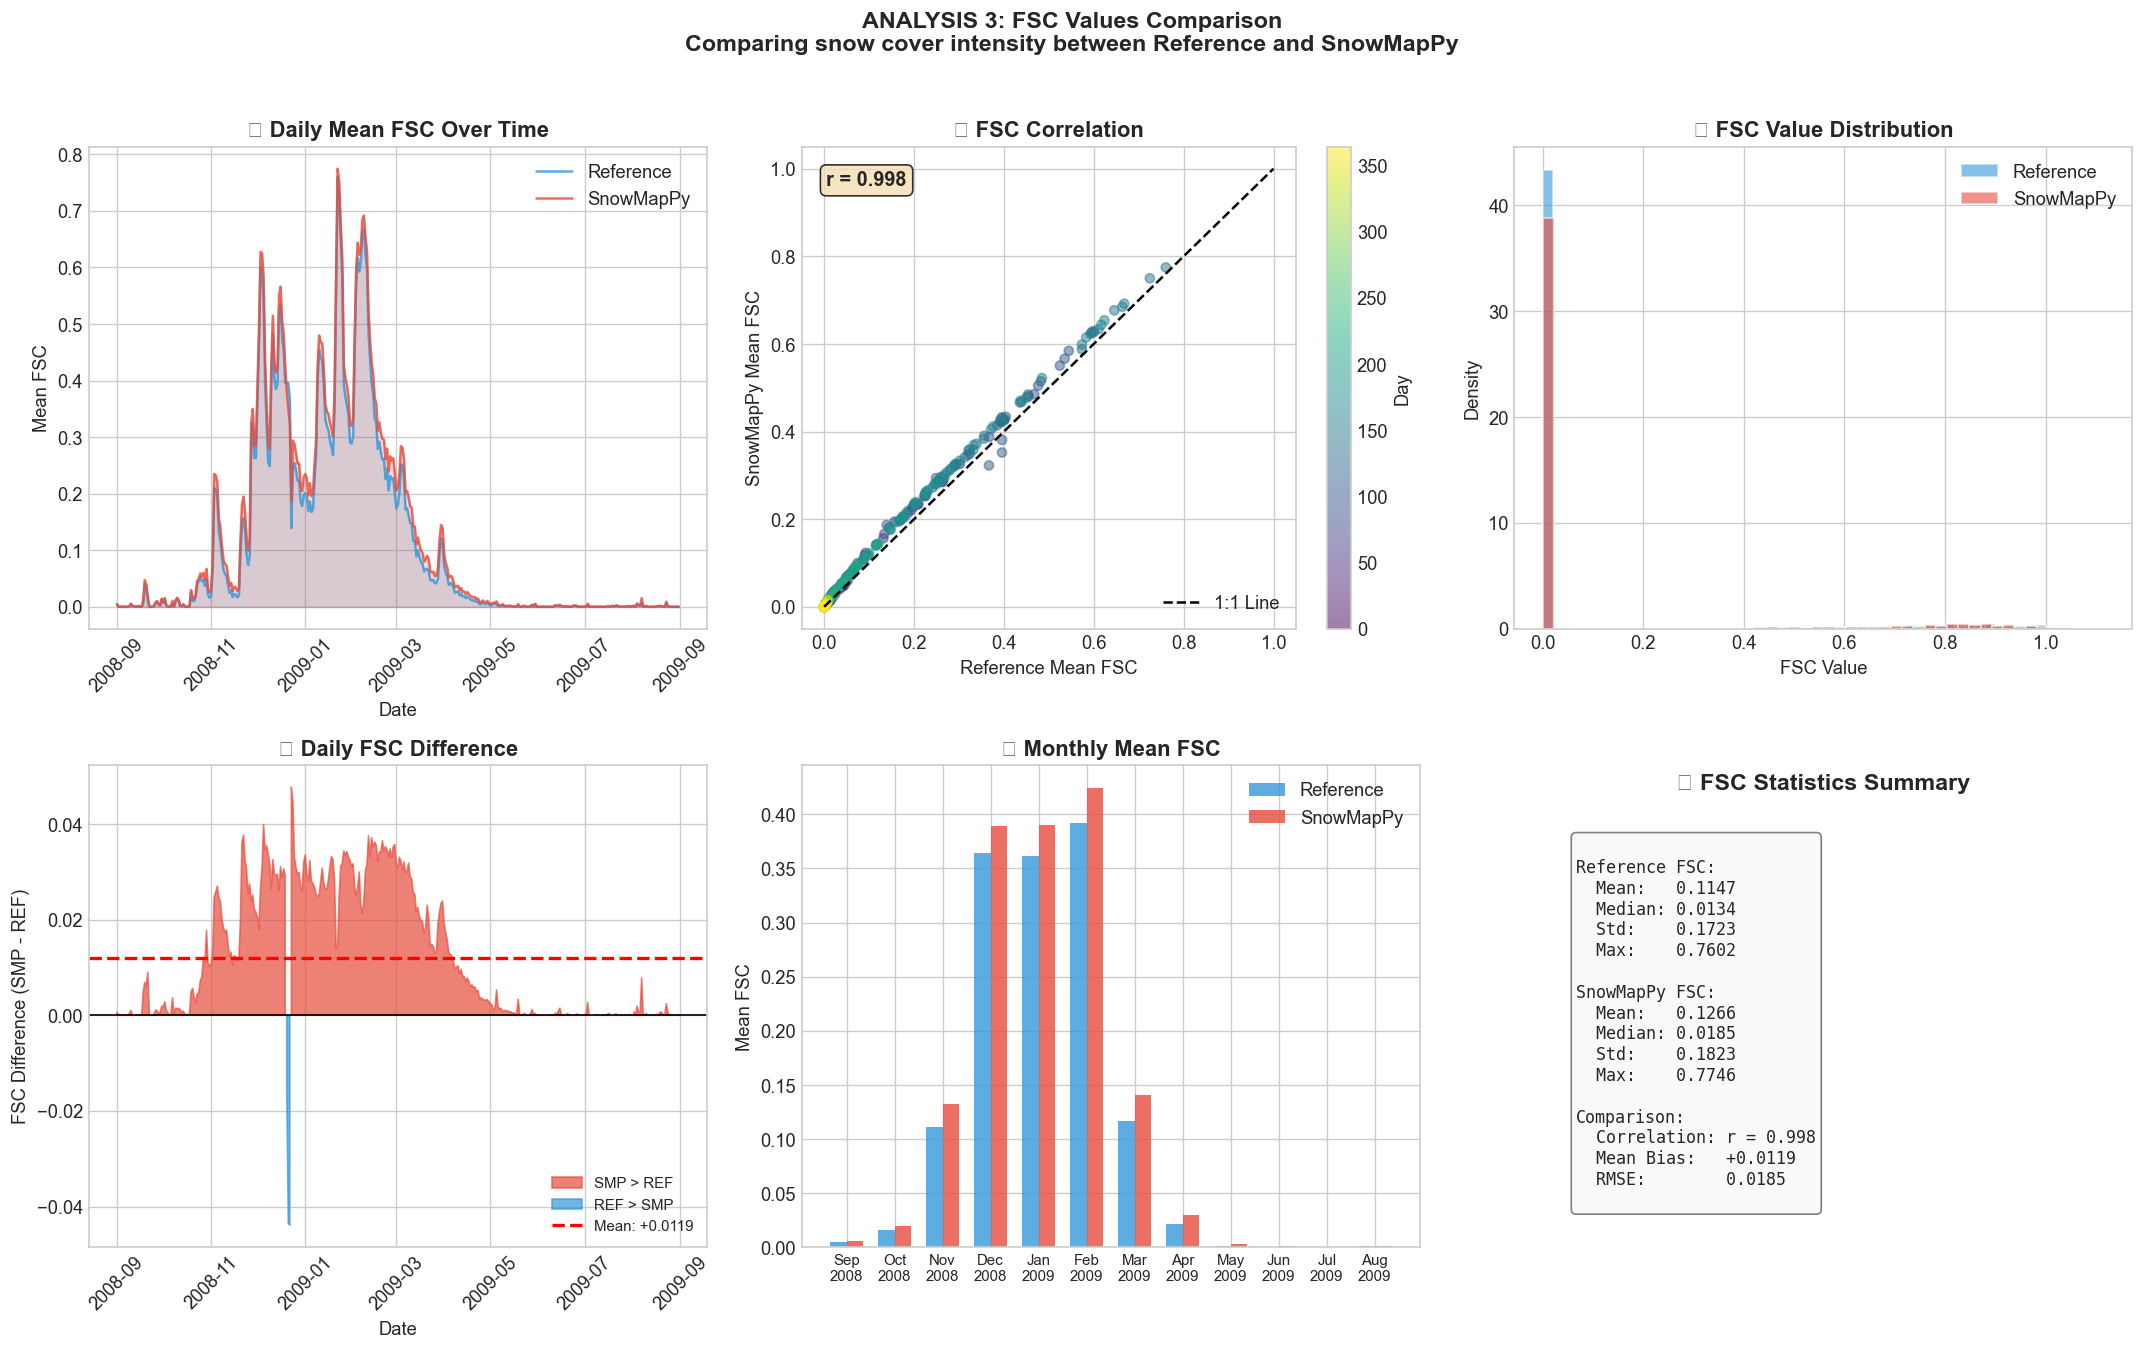

In [24]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 3: FSC VALUES COMPARISON
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: Statistical comparison of actual FSC values between methods.
# WHY IT'S USEFUL: Reveals if methods agree on snow cover intensity/extent,
#                  identifies systematic biases in snow detection.
# ═══════════════════════════════════════════════════════════════════════════════

print("Analyzing FSC values...")

# Calculate daily mean FSC (only where both have valid data)
ref_means = []
smp_means = []
for i in range(len(common_dates)):
    ref_v = ref_aligned.isel(time=i).values
    smp_v = smp_aligned.isel(time=i).values
    both_valid_mask = ~np.isnan(ref_v) & ~np.isnan(smp_v)
    if both_valid_mask.sum() > 0:
        ref_means.append(np.mean(ref_v[both_valid_mask]))
        smp_means.append(np.mean(smp_v[both_valid_mask]))
    else:
        ref_means.append(np.nan)
        smp_means.append(np.nan)

fig, axes = plt.subplots(2, 3, figsize=(18, 11))

# Plot 1: Time series of mean FSC
ax1 = axes[0, 0]
ax1.plot(common_dates, ref_means, color=REF_COLOR, linewidth=1.5, label='Reference', alpha=0.8)
ax1.plot(common_dates, smp_means, color=SMP_COLOR, linewidth=1.5, label='SnowMapPy', alpha=0.8)
ax1.fill_between(common_dates, ref_means, alpha=0.2, color=REF_COLOR)
ax1.fill_between(common_dates, smp_means, alpha=0.2, color=SMP_COLOR)
ax1.set_xlabel('Date')
ax1.set_ylabel('Mean FSC')
ax1.set_title('📈 Daily Mean FSC Over Time', fontweight='bold')
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Scatter plot of daily means
ax2 = axes[0, 1]
valid_idx = ~(np.isnan(ref_means) | np.isnan(smp_means))
scatter = ax2.scatter(np.array(ref_means)[valid_idx], np.array(smp_means)[valid_idx], 
                      alpha=0.5, c=range(sum(valid_idx)), cmap='viridis', s=30)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='1:1 Line')
corr_fsc = np.corrcoef(np.array(ref_means)[valid_idx], np.array(smp_means)[valid_idx])[0, 1]
ax2.text(0.05, 0.95, f'r = {corr_fsc:.3f}', transform=ax2.transAxes, fontsize=12, fontweight='bold',
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax2.set_xlabel('Reference Mean FSC')
ax2.set_ylabel('SnowMapPy Mean FSC')
ax2.set_title('🔗 FSC Correlation', fontweight='bold')
ax2.legend()
plt.colorbar(scatter, ax=ax2, label='Day')

# Plot 3: All pixel values histogram
ax3 = axes[0, 2]
# Sample a subset for histogram (all values would be too many)
sample_idx = np.random.choice(len(common_dates), min(50, len(common_dates)), replace=False)
ref_all = []
smp_all = []
for i in sample_idx:
    ref_v = ref_aligned.isel(time=i).values.flatten()
    smp_v = smp_aligned.isel(time=i).values.flatten()
    ref_all.extend(ref_v[~np.isnan(ref_v)])
    smp_all.extend(smp_v[~np.isnan(smp_v)])

ax3.hist(ref_all, bins=50, alpha=0.6, color=REF_COLOR, label='Reference', density=True, edgecolor='white')
ax3.hist(smp_all, bins=50, alpha=0.6, color=SMP_COLOR, label='SnowMapPy', density=True, edgecolor='white')
ax3.set_xlabel('FSC Value')
ax3.set_ylabel('Density')
ax3.set_title('📊 FSC Value Distribution', fontweight='bold')
ax3.legend()

# Plot 4: FSC difference time series
ax4 = axes[1, 0]
fsc_diff = np.array(smp_means) - np.array(ref_means)
ax4.fill_between(common_dates, fsc_diff, 0, where=(fsc_diff >= 0), alpha=0.7, color=SMP_COLOR, label='SMP > REF')
ax4.fill_between(common_dates, fsc_diff, 0, where=(fsc_diff < 0), alpha=0.7, color=REF_COLOR, label='REF > SMP')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.axhline(y=np.nanmean(fsc_diff), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.nanmean(fsc_diff):+.4f}')
ax4.set_xlabel('Date')
ax4.set_ylabel('FSC Difference (SMP - REF)')
ax4.set_title('📉 Daily FSC Difference', fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Monthly comparison
ax5 = axes[1, 1]
monthly_ref_fsc = pd.Series(ref_means, index=common_dates).resample('M').mean()
monthly_smp_fsc = pd.Series(smp_means, index=common_dates).resample('M').mean()

x = np.arange(len(monthly_ref_fsc))
width = 0.35
ax5.bar(x - width/2, monthly_ref_fsc.values, width, label='Reference', color=REF_COLOR, alpha=0.8)
ax5.bar(x + width/2, monthly_smp_fsc.values, width, label='SnowMapPy', color=SMP_COLOR, alpha=0.8)
ax5.set_xticks(x)
ax5.set_xticklabels([d.strftime('%b\n%Y') for d in monthly_ref_fsc.index], fontsize=9)
ax5.set_ylabel('Mean FSC')
ax5.set_title('📅 Monthly Mean FSC', fontweight='bold')
ax5.legend()

# Plot 6: Statistics summary
ax6 = axes[1, 2]
ax6.axis('off')
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)

ax6.text(0.5, 0.95, '📋 FSC Statistics Summary', ha='center', fontsize=14, fontweight='bold')

ref_vals = np.array(ref_means)[valid_idx]
smp_vals = np.array(smp_means)[valid_idx]

stats_text = f"""
Reference FSC:
  Mean:   {np.mean(ref_vals):.4f}
  Median: {np.median(ref_vals):.4f}
  Std:    {np.std(ref_vals):.4f}
  Max:    {np.max(ref_vals):.4f}

SnowMapPy FSC:
  Mean:   {np.mean(smp_vals):.4f}
  Median: {np.median(smp_vals):.4f}
  Std:    {np.std(smp_vals):.4f}
  Max:    {np.max(smp_vals):.4f}

Comparison:
  Correlation: r = {corr_fsc:.3f}
  Mean Bias:   {np.mean(fsc_diff[valid_idx]):+.4f}
  RMSE:        {np.sqrt(np.mean(fsc_diff[valid_idx]**2)):.4f}
"""
ax6.text(0.1, 0.85, stats_text, fontsize=10, family='monospace', va='top',
         bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='gray'))

fig.suptitle('ANALYSIS 3: FSC Values Comparison\n'
             'Comparing snow cover intensity between Reference and SnowMapPy', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

Performing spatial subtraction for 6 random days...
Selected dates: ['2008-09-16', '2008-10-04', '2008-10-28', '2009-03-03', '2009-03-13', '2009-07-07']


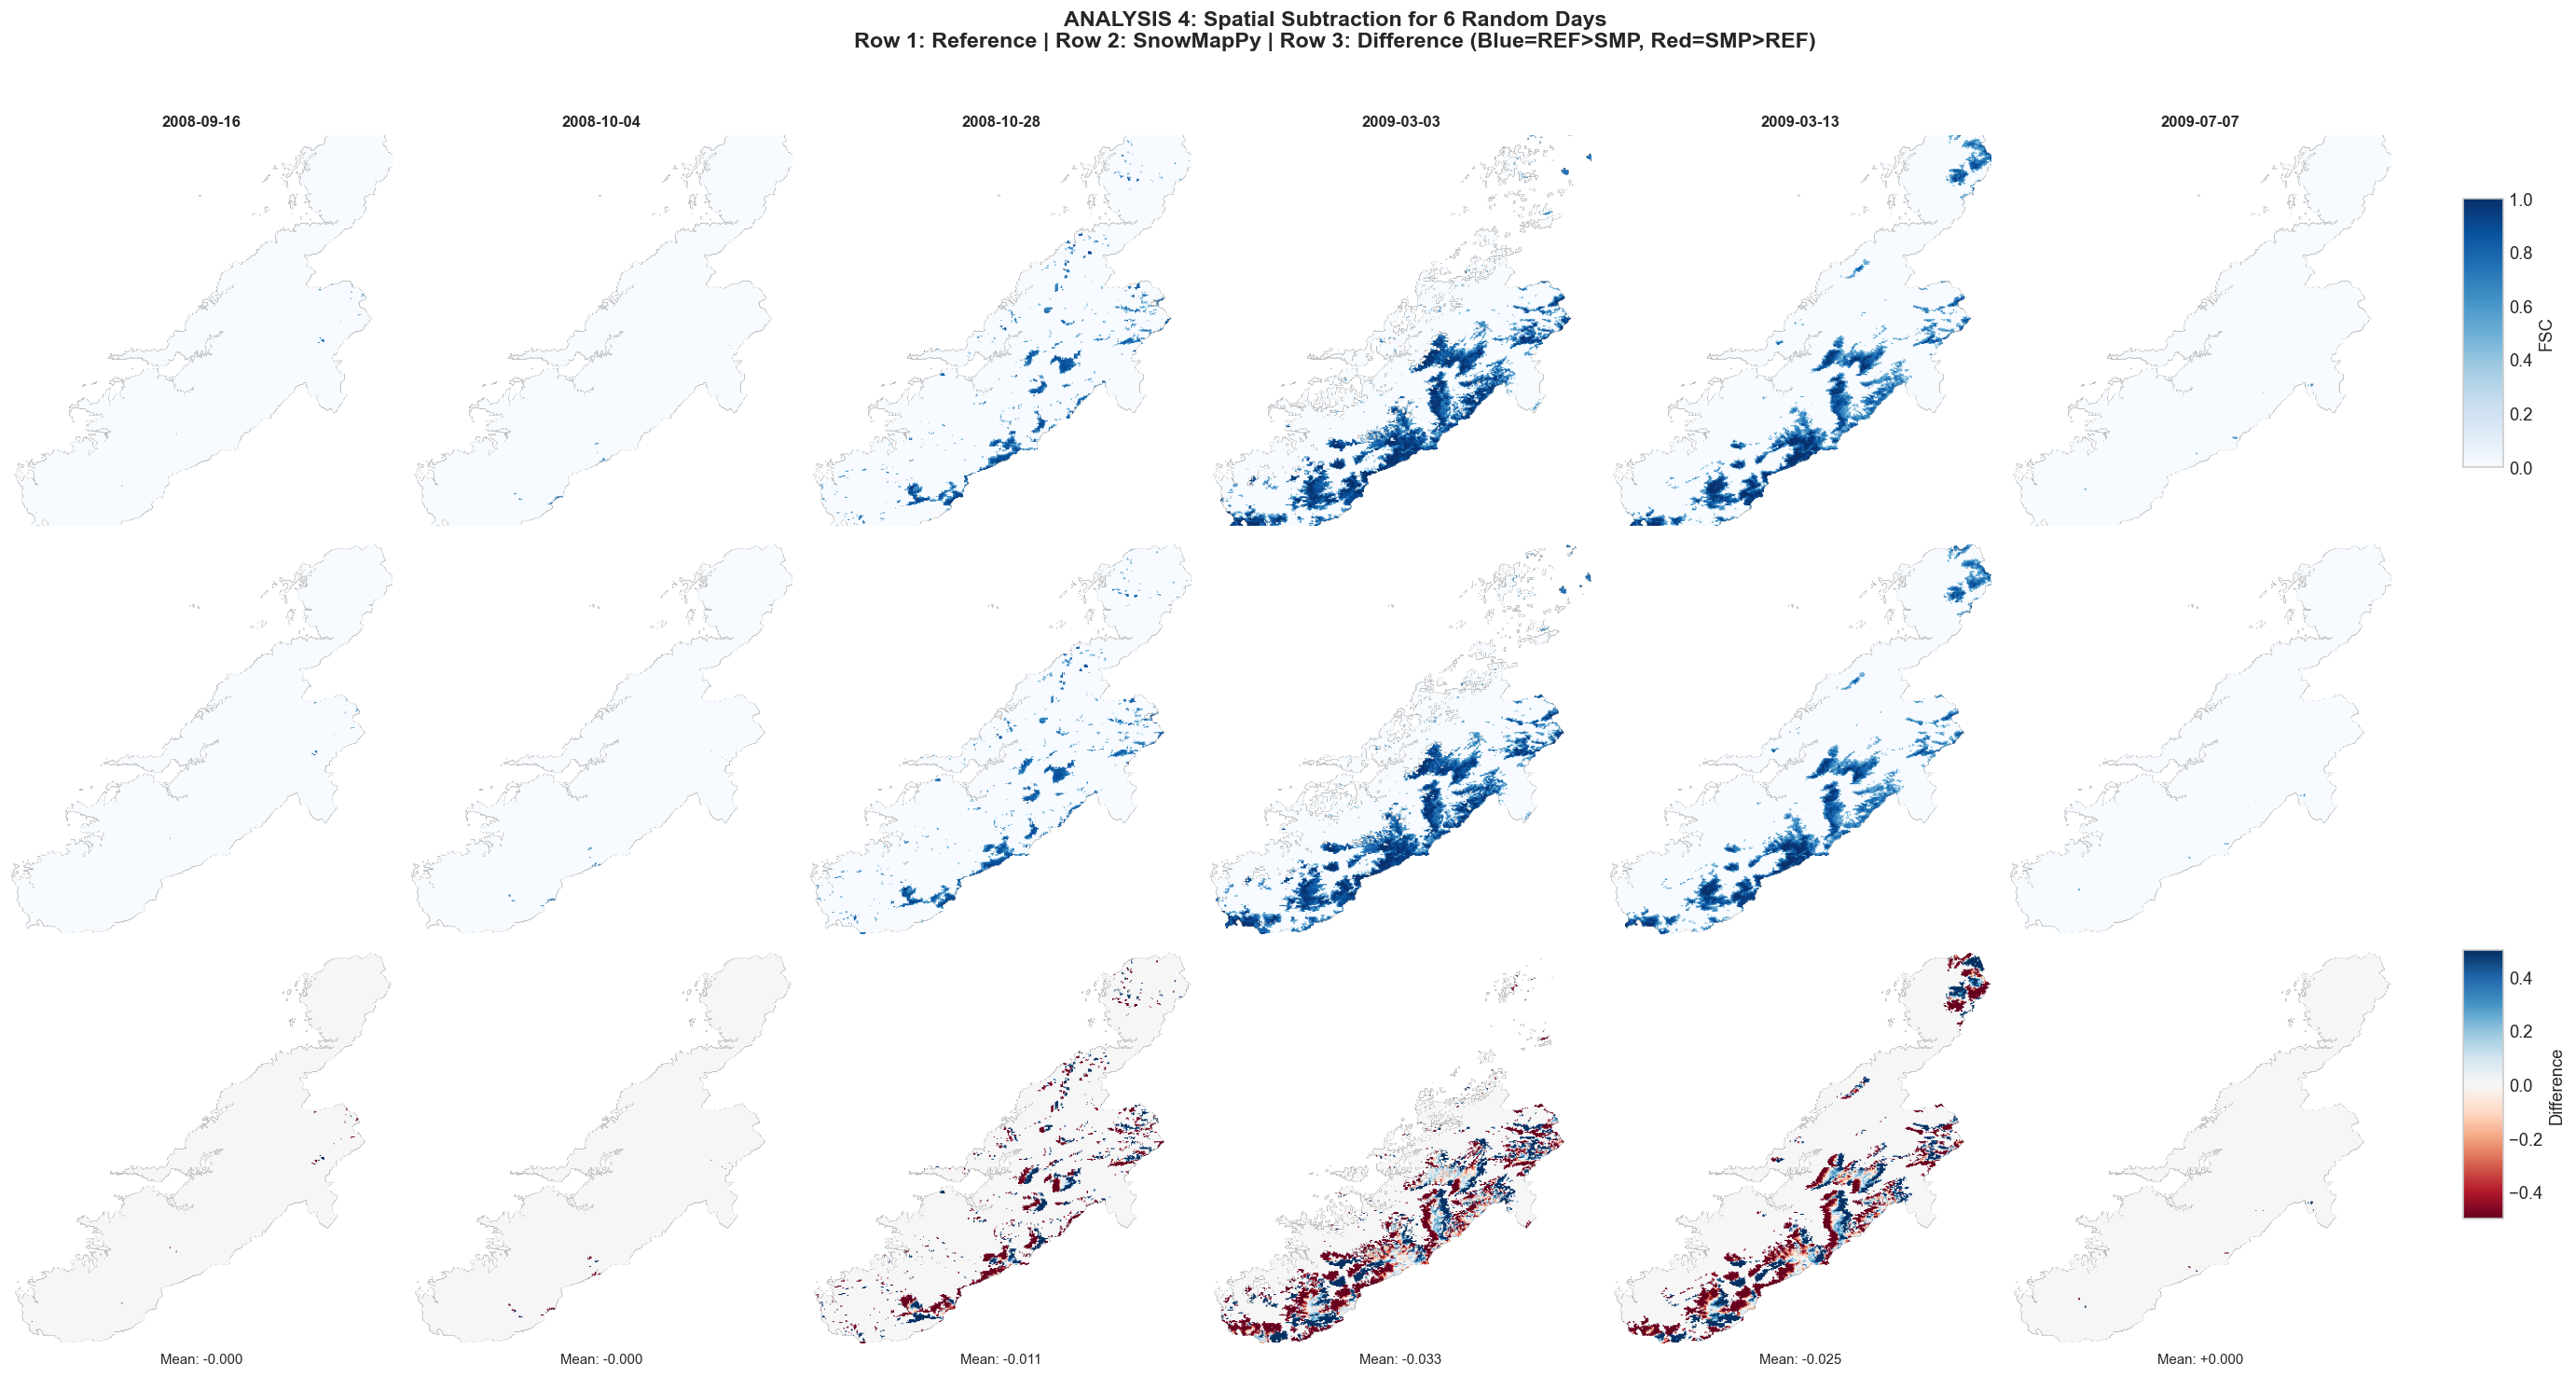

In [25]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 4: SPATIAL SUBTRACTION FOR 6 RANDOM DAYS
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: Pixel-by-pixel difference maps (Reference - SnowMapPy).
# WHY IT'S USEFUL: Reveals spatial patterns of disagreement - where and how
#                  much the methods differ geographically.
# Color interpretation: Blue = Reference higher, Red = SnowMapPy higher
# ═══════════════════════════════════════════════════════════════════════════════

print("Performing spatial subtraction for 6 random days...")

# Select 6 random days (spread across the study period)
np.random.seed(42)  # For reproducibility
random_indices = sorted(np.random.choice(len(common_dates), 6, replace=False))
random_dates = [common_dates[i] for i in random_indices]

print(f"Selected dates: {[d.strftime('%Y-%m-%d') for d in random_dates]}")

fig, axes = plt.subplots(3, 6, figsize=(24, 12))

for col, (idx, date) in enumerate(zip(random_indices, random_dates)):
    ref_img = ref_aligned.isel(time=idx).values
    smp_img = smp_aligned.isel(time=idx).values
    
    # Calculate difference (only where both valid)
    both_valid_mask = ~np.isnan(ref_img) & ~np.isnan(smp_img)
    diff_img = np.where(both_valid_mask, ref_img - smp_img, np.nan)
    
    # Row 1: Reference
    im1 = axes[0, col].imshow(ref_img, cmap='Blues', vmin=0, vmax=1, aspect='auto')
    axes[0, col].set_title(f'{date.strftime("%Y-%m-%d")}', fontweight='bold', fontsize=10)
    axes[0, col].axis('off')
    if col == 0:
        axes[0, col].set_ylabel('Reference', fontsize=12, fontweight='bold', color=REF_COLOR)
    
    # Row 2: SnowMapPy
    im2 = axes[1, col].imshow(smp_img, cmap='Blues', vmin=0, vmax=1, aspect='auto')
    axes[1, col].axis('off')
    if col == 0:
        axes[1, col].set_ylabel('SnowMapPy', fontsize=12, fontweight='bold', color=SMP_COLOR)
    
    # Row 3: Difference (Reference - SnowMapPy)
    # Use diverging colormap: blue = REF higher, red = SMP higher
    norm = TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
    im3 = axes[2, col].imshow(diff_img, cmap='RdBu', norm=norm, aspect='auto')
    axes[2, col].axis('off')
    if col == 0:
        axes[2, col].set_ylabel('Difference\n(REF - SMP)', fontsize=12, fontweight='bold', color=DIFF_COLOR)
    
    # Add statistics annotation
    mean_diff = np.nanmean(diff_img)
    axes[2, col].text(0.5, -0.05, f'Mean: {mean_diff:+.3f}', transform=axes[2, col].transAxes,
                      ha='center', fontsize=9)

# Add colorbars
cbar_ax1 = fig.add_axes([0.92, 0.68, 0.015, 0.2])
fig.colorbar(im1, cax=cbar_ax1, label='FSC')

cbar_ax3 = fig.add_axes([0.92, 0.12, 0.015, 0.2])
cbar = fig.colorbar(im3, cax=cbar_ax3, label='Difference')

fig.suptitle('ANALYSIS 4: Spatial Subtraction for 6 Random Days\n'
             'Row 1: Reference | Row 2: SnowMapPy | Row 3: Difference (Blue=REF>SMP, Red=SMP>REF)', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

Calculating temporal pixel-wise difference patterns...


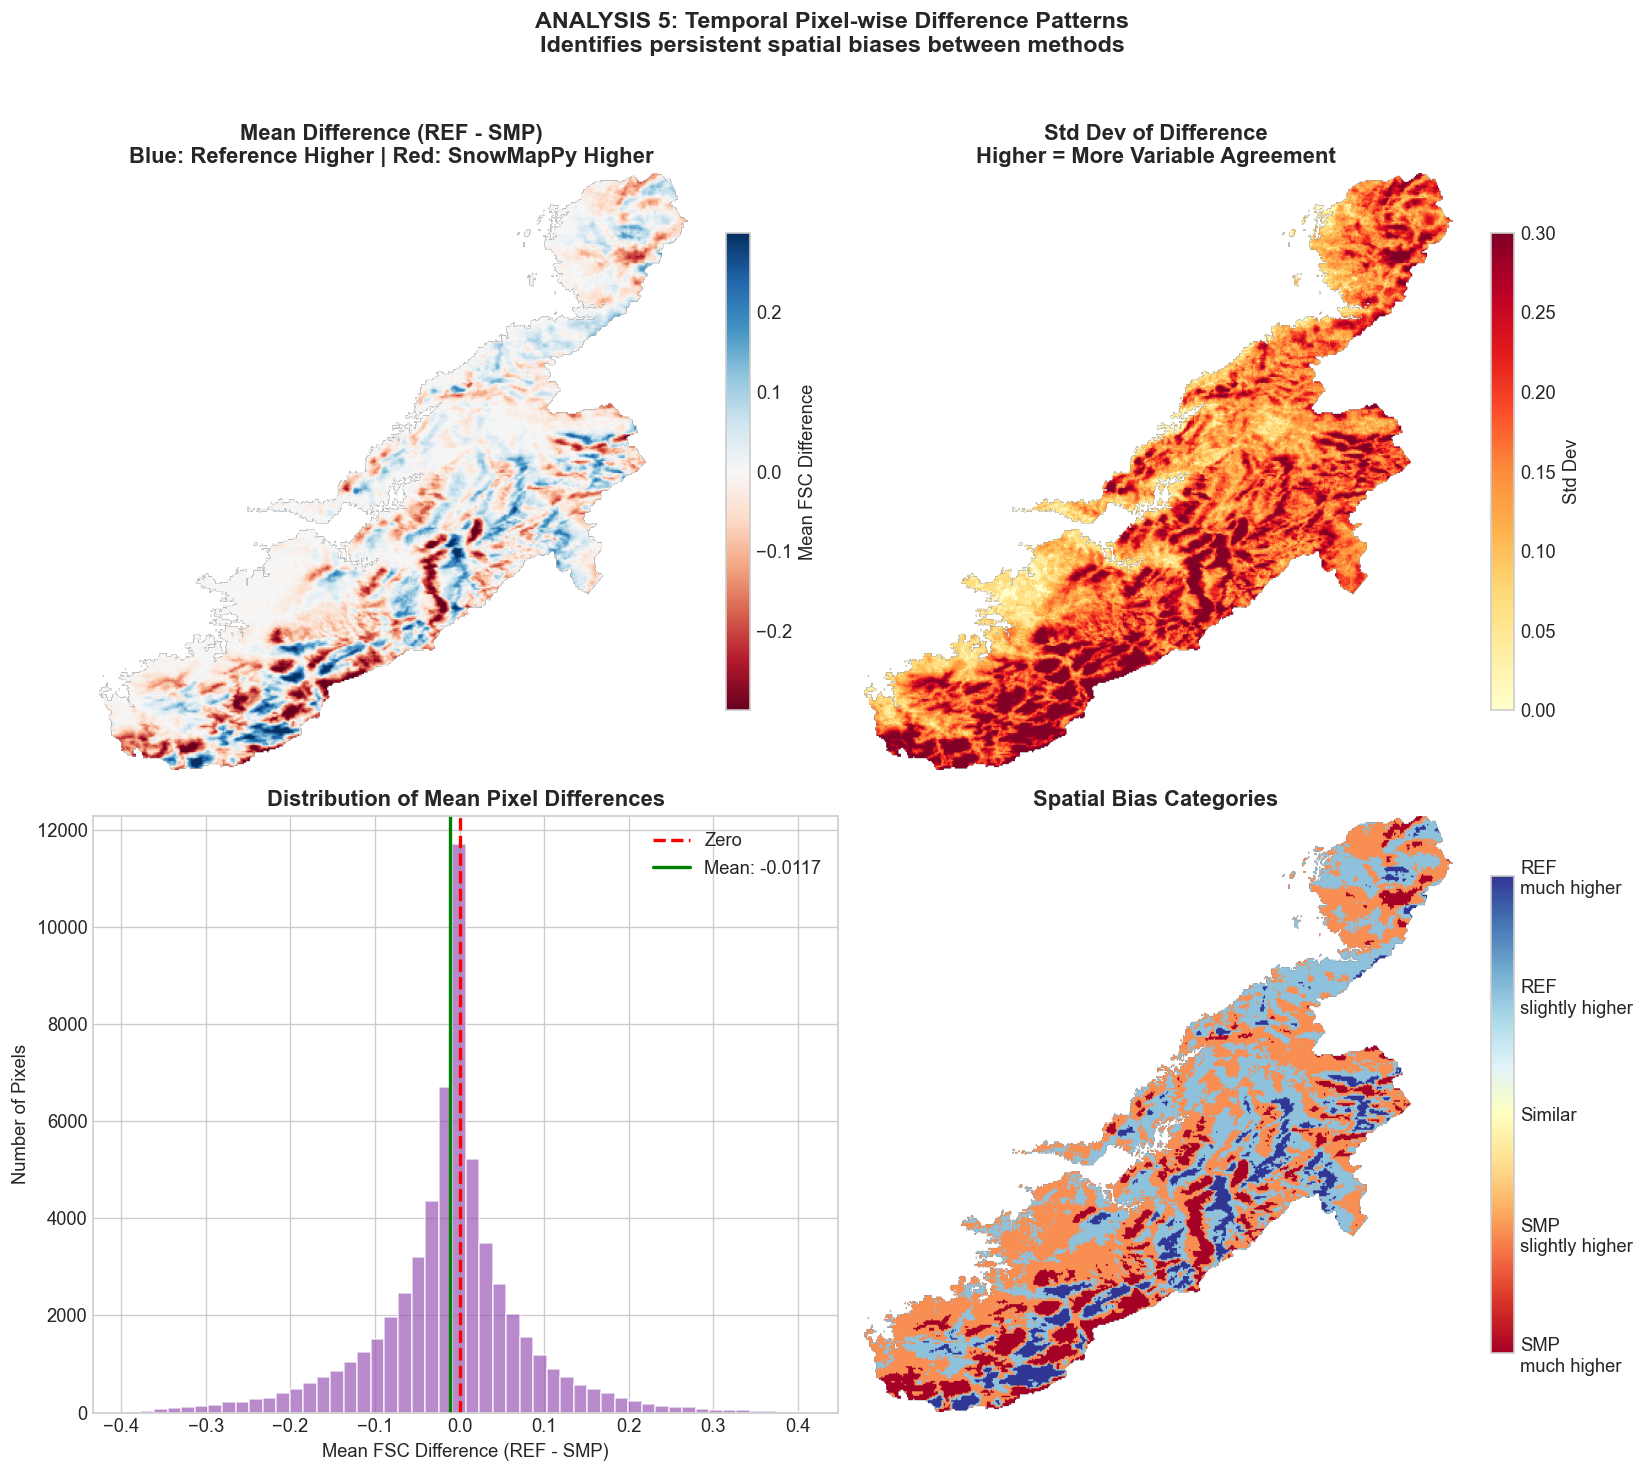


📊 Spatial Bias Summary:
   Mean difference: -0.0117 FSC
   Median difference: -0.0049 FSC
   Pixels where REF > SMP: 42.7%
   Pixels where SMP > REF: 56.6%


In [26]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 5: TEMPORAL PIXEL-WISE DIFFERENCE PATTERNS
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: Mean difference and consistency of differences at each pixel.
# WHY IT'S USEFUL: Identifies persistent spatial biases - areas where one method
#                  consistently over/under-estimates compared to the other.
# ═══════════════════════════════════════════════════════════════════════════════

print("Calculating temporal pixel-wise difference patterns...")

# Calculate mean difference at each pixel over time
diff_stack = []
for i in range(len(common_dates)):
    ref_v = ref_aligned.isel(time=i).values
    smp_v = smp_aligned.isel(time=i).values
    diff_stack.append(ref_v - smp_v)

diff_array = np.stack(diff_stack, axis=0)
mean_diff_spatial = np.nanmean(diff_array, axis=0)
std_diff_spatial = np.nanstd(diff_array, axis=0)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Mean difference map
ax1 = axes[0, 0]
norm1 = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)
im1 = ax1.imshow(mean_diff_spatial, cmap='RdBu', norm=norm1, aspect='auto')
ax1.set_title('Mean Difference (REF - SMP)\nBlue: Reference Higher | Red: SnowMapPy Higher', fontweight='bold')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, label='Mean FSC Difference', shrink=0.8)

# Plot 2: Standard deviation of difference
ax2 = axes[0, 1]
im2 = ax2.imshow(std_diff_spatial, cmap='YlOrRd', vmin=0, vmax=0.3, aspect='auto')
ax2.set_title('Std Dev of Difference\nHigher = More Variable Agreement', fontweight='bold')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, label='Std Dev', shrink=0.8)

# Plot 3: Histogram of mean differences
ax3 = axes[1, 0]
valid_diff = mean_diff_spatial[~np.isnan(mean_diff_spatial)].flatten()
ax3.hist(valid_diff, bins=50, color=DIFF_COLOR, alpha=0.7, edgecolor='white')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax3.axvline(x=np.mean(valid_diff), color='green', linestyle='-', linewidth=2, 
            label=f'Mean: {np.mean(valid_diff):+.4f}')
ax3.set_xlabel('Mean FSC Difference (REF - SMP)')
ax3.set_ylabel('Number of Pixels')
ax3.set_title('Distribution of Mean Pixel Differences', fontweight='bold')
ax3.legend()

# Plot 4: Bias categories
ax4 = axes[1, 1]
# Create bias category map
bias_map = np.zeros_like(mean_diff_spatial)
bias_map[mean_diff_spatial > 0.1] = 2   # REF much higher
bias_map[(mean_diff_spatial > 0) & (mean_diff_spatial <= 0.1)] = 1  # REF slightly higher
bias_map[(mean_diff_spatial >= -0.1) & (mean_diff_spatial <= 0)] = -1  # SMP slightly higher
bias_map[mean_diff_spatial < -0.1] = -2  # SMP much higher
bias_map[np.isnan(mean_diff_spatial)] = np.nan

im4 = ax4.imshow(bias_map, cmap='RdYlBu', vmin=-2, vmax=2, aspect='auto')
ax4.set_title('Spatial Bias Categories', fontweight='bold')
ax4.axis('off')
cbar4 = plt.colorbar(im4, ax=ax4, ticks=[-2, -1, 0, 1, 2], shrink=0.8)
cbar4.ax.set_yticklabels(['SMP\nmuch higher', 'SMP\nslightly higher', 'Similar', 
                          'REF\nslightly higher', 'REF\nmuch higher'])

fig.suptitle('ANALYSIS 5: Temporal Pixel-wise Difference Patterns\n'
             'Identifies persistent spatial biases between methods', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

print(f"\n📊 Spatial Bias Summary:")
print(f"   Mean difference: {np.mean(valid_diff):+.4f} FSC")
print(f"   Median difference: {np.median(valid_diff):+.4f} FSC")
print(f"   Pixels where REF > SMP: {(valid_diff > 0).sum() / len(valid_diff) * 100:.1f}%")
print(f"   Pixels where SMP > REF: {(valid_diff < 0).sum() / len(valid_diff) * 100:.1f}%")

Analyzing snow detection agreement...


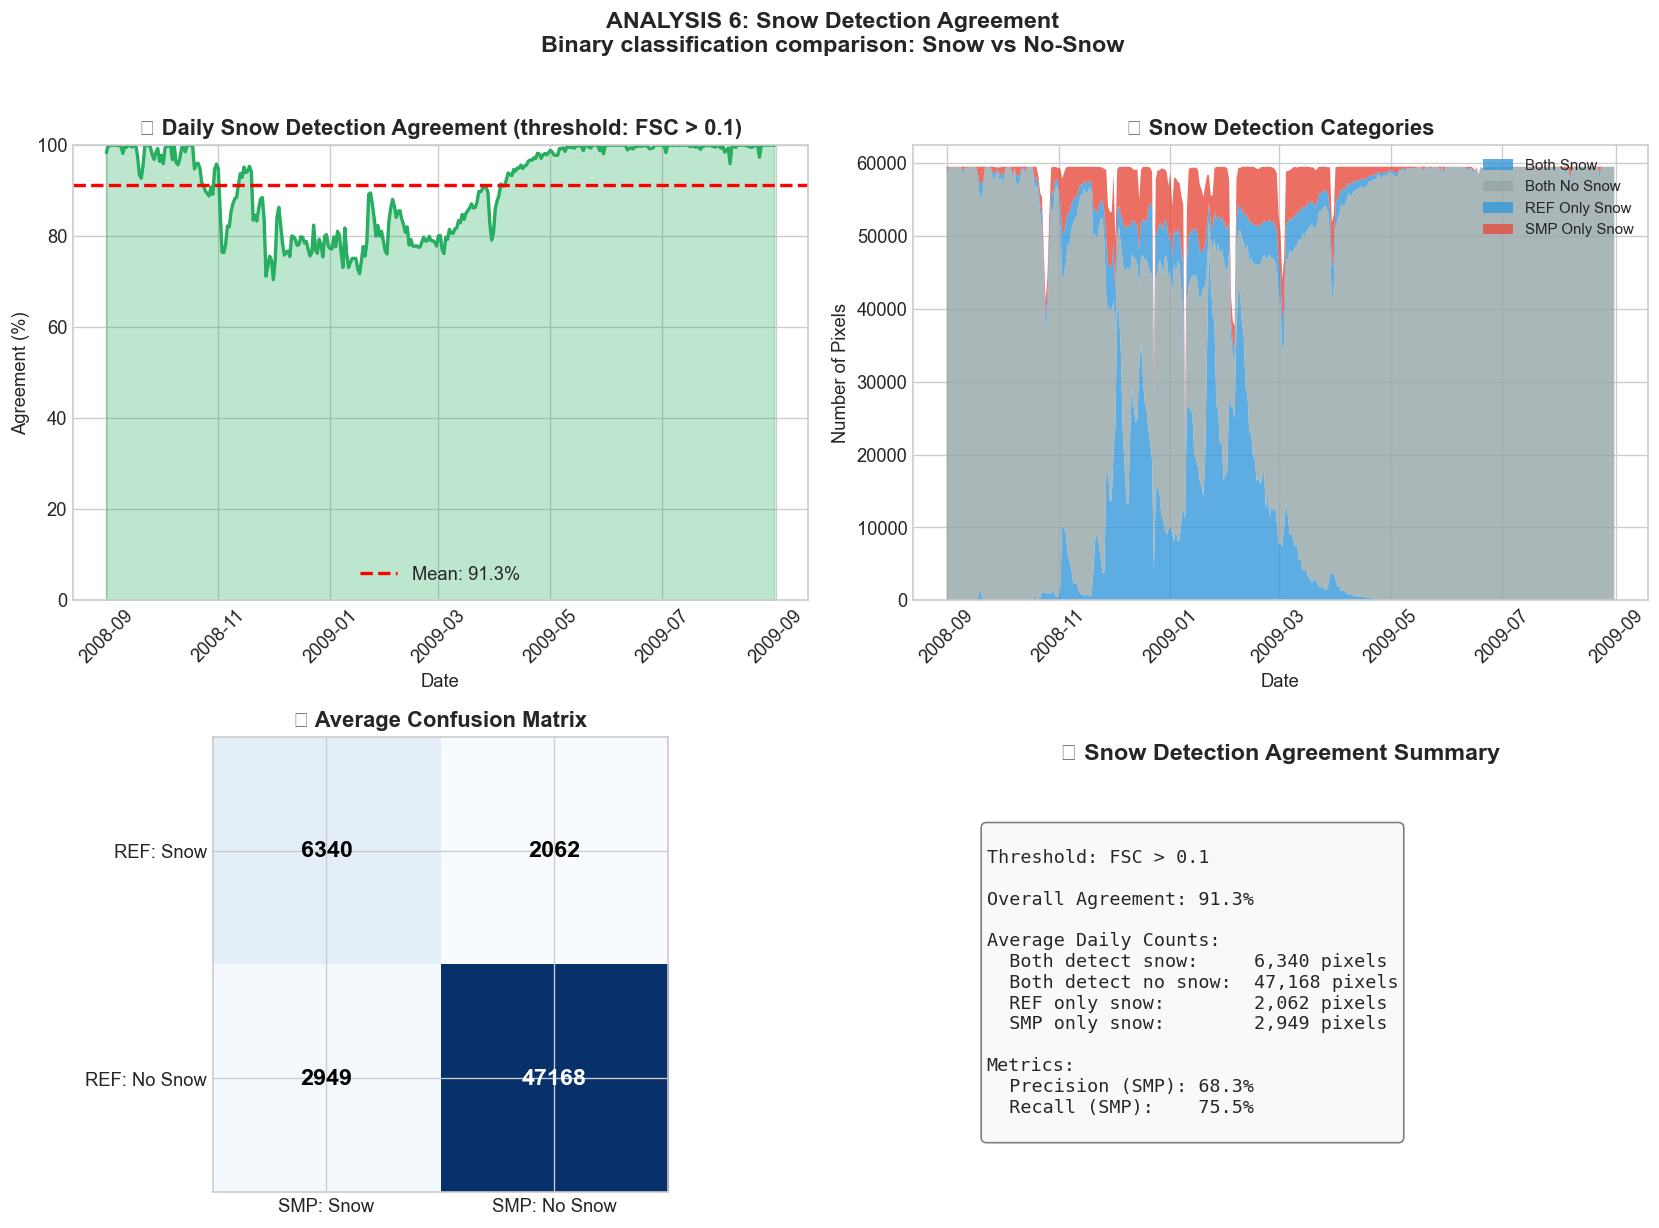

In [27]:
# ═══════════════════════════════════════════════════════════════════════════════
# ANALYSIS 6: SNOW DETECTION AGREEMENT
# ═══════════════════════════════════════════════════════════════════════════════
# WHAT IT SHOWS: How often both methods agree on snow presence/absence.
# WHY IT'S USEFUL: Quantifies classification agreement independent of FSC values.
#                  Important for binary snow mapping applications.
# ═══════════════════════════════════════════════════════════════════════════════

print("Analyzing snow detection agreement...")

# Define snow threshold (FSC > 0.1 = snow)
snow_threshold = 0.1

# Calculate agreement categories for each day
both_snow = []      # Both detect snow
both_no_snow = []   # Both detect no snow
ref_only_snow = []  # Only Reference detects snow
smp_only_snow = []  # Only SnowMapPy detects snow

for i in range(len(common_dates)):
    ref_v = ref_aligned.isel(time=i).values
    smp_v = smp_aligned.isel(time=i).values
    
    # Only consider pixels where both have valid data
    both_valid = ~np.isnan(ref_v) & ~np.isnan(smp_v)
    
    ref_snow = (ref_v > snow_threshold) & both_valid
    smp_snow = (smp_v > snow_threshold) & both_valid
    
    both_snow.append((ref_snow & smp_snow).sum())
    both_no_snow.append((~ref_snow & ~smp_snow & both_valid).sum())
    ref_only_snow.append((ref_snow & ~smp_snow).sum())
    smp_only_snow.append((~ref_snow & smp_snow).sum())

# Calculate agreement percentage
total_valid = np.array(both_snow) + np.array(both_no_snow) + np.array(ref_only_snow) + np.array(smp_only_snow)
agreement_pct = (np.array(both_snow) + np.array(both_no_snow)) / total_valid * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Agreement time series
ax1 = axes[0, 0]
ax1.plot(common_dates, agreement_pct, color='#27ae60', linewidth=2)
ax1.fill_between(common_dates, agreement_pct, alpha=0.3, color='#27ae60')
ax1.axhline(y=np.mean(agreement_pct), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(agreement_pct):.1f}%')
ax1.set_xlabel('Date')
ax1.set_ylabel('Agreement (%)')
ax1.set_title(f'🎯 Daily Snow Detection Agreement (threshold: FSC > {snow_threshold})', fontweight='bold')
ax1.legend()
ax1.set_ylim(0, 100)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Stacked area of categories
ax2 = axes[0, 1]
ax2.stackplot(common_dates, both_snow, both_no_snow, ref_only_snow, smp_only_snow,
              labels=['Both Snow', 'Both No Snow', 'REF Only Snow', 'SMP Only Snow'],
              colors=['#3498db', '#95a5a6', REF_COLOR, SMP_COLOR], alpha=0.8)
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Pixels')
ax2.set_title('📊 Snow Detection Categories', fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Confusion matrix (average)
ax3 = axes[1, 0]
conf_matrix = np.array([
    [np.mean(both_snow), np.mean(ref_only_snow)],
    [np.mean(smp_only_snow), np.mean(both_no_snow)]
])
im3 = ax3.imshow(conf_matrix, cmap='Blues')
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['SMP: Snow', 'SMP: No Snow'])
ax3.set_yticklabels(['REF: Snow', 'REF: No Snow'])
ax3.set_title('📋 Average Confusion Matrix', fontweight='bold')

# Add text annotations
for i in range(2):
    for j in range(2):
        ax3.text(j, i, f'{conf_matrix[i, j]:.0f}', ha='center', va='center', 
                 fontsize=14, fontweight='bold', color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

# Plot 4: Summary statistics
ax4 = axes[1, 1]
ax4.axis('off')
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

ax4.text(0.5, 0.95, '📋 Snow Detection Agreement Summary', ha='center', fontsize=14, fontweight='bold')

# Calculate metrics
total_agreement = np.mean(agreement_pct)
precision = np.mean(both_snow) / (np.mean(both_snow) + np.mean(smp_only_snow)) * 100
recall = np.mean(both_snow) / (np.mean(both_snow) + np.mean(ref_only_snow)) * 100

stats_text = f"""
Threshold: FSC > {snow_threshold}

Overall Agreement: {total_agreement:.1f}%

Average Daily Counts:
  Both detect snow:     {np.mean(both_snow):,.0f} pixels
  Both detect no snow:  {np.mean(both_no_snow):,.0f} pixels
  REF only snow:        {np.mean(ref_only_snow):,.0f} pixels
  SMP only snow:        {np.mean(smp_only_snow):,.0f} pixels

Metrics:
  Precision (SMP): {precision:.1f}%
  Recall (SMP):    {recall:.1f}%
"""
ax4.text(0.1, 0.8, stats_text, fontsize=11, family='monospace', va='top',
         bbox=dict(boxstyle='round', facecolor='#f8f9fa', edgecolor='gray'))

fig.suptitle('ANALYSIS 6: Snow Detection Agreement\n'
             'Binary classification comparison: Snow vs No-Snow', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [28]:
# ═══════════════════════════════════════════════════════════════════════════════
# EXECUTIVE SUMMARY
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "═" * 70)
print("                    FSC COMPARISON - EXECUTIVE SUMMARY")
print("═" * 70)

print(f"\n📋 STUDY DETAILS:")
print(f"   Period: {common_dates[0].date()} to {common_dates[-1].date()} ({len(common_dates)} days)")
print(f"   Grid size: {ref_aligned.shape[1]} x {ref_aligned.shape[2]} pixels")
print(f"   Watershed: Oum Er-Rabia")
print(f"   NDSI to FSC: FSC = 0.865 × NDSI + 0.26 (threshold: NDSI ≥ 0.2)")

print(f"\n📊 DATA AVAILABILITY:")
print(f"   Reference: {np.mean(ref_valid_pct):.1f}% valid pixels (avg)")
print(f"   SnowMapPy: {np.mean(smp_valid_pct):.1f}% valid pixels (avg)")
print(f"   Both Valid: {np.mean(both_valid)/total_pixels*100:.1f}% (avg)")

print(f"\n❄️ FSC COMPARISON:")
print(f"   Correlation: r = {corr_fsc:.3f}")
print(f"   Mean Bias (SMP - REF): {np.nanmean(fsc_diff):+.4f}")
print(f"   RMSE: {np.sqrt(np.nanmean(fsc_diff**2)):.4f}")

print(f"\n🎯 SNOW DETECTION AGREEMENT:")
print(f"   Overall Agreement: {total_agreement:.1f}%")
print(f"   Precision: {precision:.1f}%")
print(f"   Recall: {recall:.1f}%")

print(f"\n📍 SPATIAL BIAS:")
print(f"   Mean spatial difference: {np.mean(valid_diff):+.4f}")
print(f"   Pixels where REF > SMP: {(valid_diff > 0).sum() / len(valid_diff) * 100:.1f}%")
print(f"   Pixels where SMP > REF: {(valid_diff < 0).sum() / len(valid_diff) * 100:.1f}%")

print("\n" + "═" * 70)
print("                    ANALYSIS COMPLETE")
print("═" * 70)


══════════════════════════════════════════════════════════════════════
                    FSC COMPARISON - EXECUTIVE SUMMARY
══════════════════════════════════════════════════════════════════════

📋 STUDY DETAILS:
   Period: 2008-09-01 to 2009-08-31 (365 days)
   Grid size: 404 x 486 pixels
   Watershed: Oum Er-Rabia
   NDSI to FSC: FSC = 0.865 × NDSI + 0.26 (threshold: NDSI ≥ 0.2)

📊 DATA AVAILABILITY:
   Reference: 33.4% valid pixels (avg)
   SnowMapPy: 32.5% valid pixels (avg)
   Both Valid: 0.0% (avg)

❄️ FSC COMPARISON:
   Correlation: r = 0.998
   Mean Bias (SMP - REF): +0.0119
   RMSE: 0.0185

🎯 SNOW DETECTION AGREEMENT:
   Overall Agreement: 91.3%
   Precision: 68.3%
   Recall: 75.5%

📍 SPATIAL BIAS:
   Mean spatial difference: -0.0117
   Pixels where REF > SMP: 42.7%
   Pixels where SMP > REF: 56.6%

══════════════════════════════════════════════════════════════════════
                    ANALYSIS COMPLETE
════════════════════════════════════════════════════════════════════